### merge_data 파일을 통해 만들어진 최적화된 파일로 데이터를 분석하기

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pyarrow.parquet as pq
import tqdm
import optuna

# test 데이터 준비 (샘플로 train에서 분리)
from sklearn.model_selection import train_test_split

# 모델 학습 및 평가
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score


# notebook이 있는 디렉토리를 절대경로로 설정
notebook_dir = r'c:\Users\Administrator\github\Credit-Card-Segment\LGW'

# sys.path에 추가 (중복 확인)
if notebook_dir not in sys.path:
    sys.path.insert(0, notebook_dir)

# 작업 디렉토리 변경
os.chdir(notebook_dir)

from corr_dict import corr_dict

In [3]:
HOME = os.getcwd()
list_dir = os.listdir(HOME)

In [4]:
list_dir

['1.corr.common.txt',
 '1.corr.txt',
 '2.corr.txt',
 '3.corr.txt',
 '4.corr.txt',
 '5.corr.txt',
 '6.corr.txt',
 '7.corr.txt',
 '8.corr.txt',
 'catboost_info',
 'corr_dict.py',
 'corr_Name_backup.txt',
 'credit_preprocessing_month_10.parquet',
 'credit_preprocessing_month_11.parquet',
 'credit_preprocessing_month_12.parquet',
 'credit_preprocessing_month_7.parquet',
 'credit_preprocessing_month_8.parquet',
 'credit_preprocessing_month_9.parquet',
 'data',
 'Data_Analysis.ipynb',
 'Data_Analysis_Lite.ipynb',
 'LGW Read me',
 'merge_data.ipynb',
 'merge_data_feedback.ipynb',
 'Segment_Correlation_Pearson',
 'Segment_Correlation_Spearman.txt',
 'test',
 '__pycache__']

### 시작 전 준비
 - 858개라는 방대한 데이터를 가지게 됬지만, 이는 세부적인 사항을 고려하지 못할수도 있다. 따라서, 나중에 세부사항을 파악하기 위해서 따로 사용할 코드를 하나 더 만들어 놓는다.

In [5]:
# 각 폴더명 딕셔너리
folder_name = {1:"1.회원정보", 2:"2.신용정보", 3:"3.승인매출정보", 4:"4.청구입금정보", 5:"5.잔액정보", 6:"6.채널정보", 7:"7.마케팅정보", 8:"8.성과정보"}

# 현재 디렉터리
HOME = os.getcwd()

# 폴더 리스트를 생성하고 폴더 경로들을 리스트로 저장하기
folder_list = []
for value in folder_name.values():
    folder_list.append(os.path.join(HOME, "data", "train", value))
print(len(folder_list))

# 폴더 내 파일 리스트 읽어오기
fileNameList = {}
for i in range(len(folder_list)):
    fileNameList[i+1] = os.listdir(folder_list[i])
print(fileNameList)

# 파일 경로 리스트 생성
filePathList = {}
temp = []
for i in range(len(folder_list)):
    for j in range(len(fileNameList[i+1])):
        temp.append(os.path.join(folder_list[i], fileNameList[i+1][j]))
    filePathList[i+1] = temp
    temp = []

print(filePathList)

8
{1: ['201807_train_회원정보.parquet', '201808_train_회원정보.parquet', '201809_train_회원정보.parquet', '201810_train_회원정보.parquet', '201811_train_회원정보.parquet', '201812_train_회원정보.parquet'], 2: ['201807_train_신용정보.parquet', '201808_train_신용정보.parquet', '201809_train_신용정보.parquet', '201810_train_신용정보.parquet', '201811_train_신용정보.parquet', '201812_train_신용정보.parquet'], 3: ['201807_train_승인매출정보.parquet', '201808_train_승인매출정보.parquet', '201809_train_승인매출정보.parquet', '201810_train_승인매출정보.parquet', '201811_train_승인매출정보.parquet', '201812_train_승인매출정보.parquet'], 4: ['201807_train_청구정보.parquet', '201808_train_청구정보.parquet', '201809_train_청구정보.parquet', '201810_train_청구정보.parquet', '201811_train_청구정보.parquet', '201812_train_청구정보.parquet'], 5: ['201807_train_잔액정보.parquet', '201808_train_잔액정보.parquet', '201809_train_잔액정보.parquet', '201810_train_잔액정보.parquet', '201811_train_잔액정보.parquet', '201812_train_잔액정보.parquet'], 6: ['201807_train_채널정보.parquet', '201808_train_채널정보.parquet', '201809_train_채널정보.parquet',

In [6]:
# list에 나중에 불러올 파일들을 저장하기
df_list = list(filter(lambda x: x.endswith('.parquet'), list_dir))
df_list = sorted(df_list, key=lambda x: int(re.search(r'\d+', x).group()))
print(df_list)

['credit_preprocessing_month_7.parquet', 'credit_preprocessing_month_8.parquet', 'credit_preprocessing_month_9.parquet', 'credit_preprocessing_month_10.parquet', 'credit_preprocessing_month_11.parquet', 'credit_preprocessing_month_12.parquet']


In [7]:
# 최적화해둔 전체 파일 불러오기
option = 1 # 0 : 하나만 불러오기, 1 : 데이터 전체를 합병해서 불러오기
if option == 0:
    df = pd.read_parquet(df_list[0], engine='fastparquet')
if option == 1:
    df = pd.read_parquet(df_list[0], engine = "fastparquet")
    for i in range(1, 6):
        temp = pd.read_parquet(df_list[i], engine = "fastparquet")
        df = pd.concat([df, temp])
df
        

,기준년월,ID,남녀구분코드,연령,Segment,회원여부_이용가능,회원여부_이용가능_CA,회원여부_이용가능_카드론,소지여부_신용,소지카드수_유효_신용,...,변동률_RV일시불평잔,변동률_할부평잔,변동률_CA평잔,변동률_RVCA평잔,변동률_카드론평잔,변동률_잔액_B1M,변동률_잔액_일시불_B1M,변동률_잔액_CA_B1M,혜택수혜율_R3M,혜택수혜율_B0M
0,201807,TRAIN_000000,2,40대,D,1,1,0,1,1,...,0.999998,1.042805,0.999700,0.999998,0.999998,0.261886,0.270752,0.000000,1.044401,1.280542
1,201807,TRAIN_000001,1,30대,E,1,1,1,1,1,...,1.092698,0.905663,0.999998,0.999998,0.999998,-0.563388,-0.670348,0.000000,0.000000,0.000000
2,201807,TRAIN_000002,1,30대,C,1,1,0,1,1,...,1.006124,1.993590,0.852567,0.999998,0.999998,-0.046516,0.058114,-0.014191,0.524159,1.208420
3,201807,TRAIN_000003,2,40대,D,1,1,0,1,2,...,0.999998,1.050646,0.999877,0.999998,0.999998,0.023821,0.258943,0.000000,0.880925,1.657124
4,201807,TRAIN_000004,2,40대,E,1,1,1,1,1,...,0.999998,0.999998,0.999998,0.999998,0.999998,0.000000,0.000000,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,201812,TRAIN_399995,2,70대이상,E,1,1,1,1,1,...,0.999998,0.999998,0.999998,0.999998,0.999998,0.000000,0.000000,0.000000,NaN,NaN
399996,201812,TRAIN_399996,2,50대,D,1,1,1,1,1,...,0.999998,0.999998,0.999998,0.999998,0.921733,-0.203251,-0.159143,0.000000,1.377071,2.533815
399997,201812,TRAIN_399997,1,30대,C,1,1,0,1,1,...,0.999998,0.345027,0.999998,0.999998,0.999998,0.027319,0.126581,0.000000,0.000000,0.000000
399998,201812,TRAIN_399998,1,40대,E,1,1,1,1,1,...,0.999998,0.999998,0.999998,0.999998,0.999998,0.000000,0.000000,0.000000,NaN,NaN


### 1. 탐색적 분석
 - 기준년월, ID는 삭제한다.
 - 현재 Segment의 count수를 확인하여 데이터의 균형상태를 확인한다.
 - 문자열의 형태의 데이터를 가진 column의 개수를 확인하고, 이후 어떤 내용인지 파악을 위해 따로 빼놓는다.
 - 먼저, Segment를 숫자로 변환한 뒤 각 항목에 대해 상관관계를 파악한다. 이 때, 문자열의 경우 문자열을 변환하여 사용하는데, 매핑이 잘 되는 편은 아니기에 따로 작업할 필요가 있다.
 - **Segment는 반드시 숫자로 매핑한 이후 사용한다.**

In [8]:
df.info()

<class 'pandas.DataFrame'>
Index: 2400000 entries, 0 to 399999
Columns: 858 entries, 기준년월 to 혜택수혜율_B0M
dtypes: float32(57), float64(4), int16(148), int32(147), int8(452), object(50)
memory usage: 4.5+ GB


 - 총 50개의 문자열 데이터가 존재하고, 나머지 808개의 데이터는 모두 숫자이다.
 - 현재 너무 많은 column의 개수때문에 자료의 정밀도를 위해 전체적인 상관관계를 한 번 파악한 뒤, 원본 파일들의 column을 가져와 나누는게 편할듯하다.

In [9]:
# 원본 파일의 column만 추출하여 리스트로 저장하는 코드
test1 = pq.read_metadata(filePathList[1][0])
# test1.schema.names # 원본 파일의 컬럼명 리스트

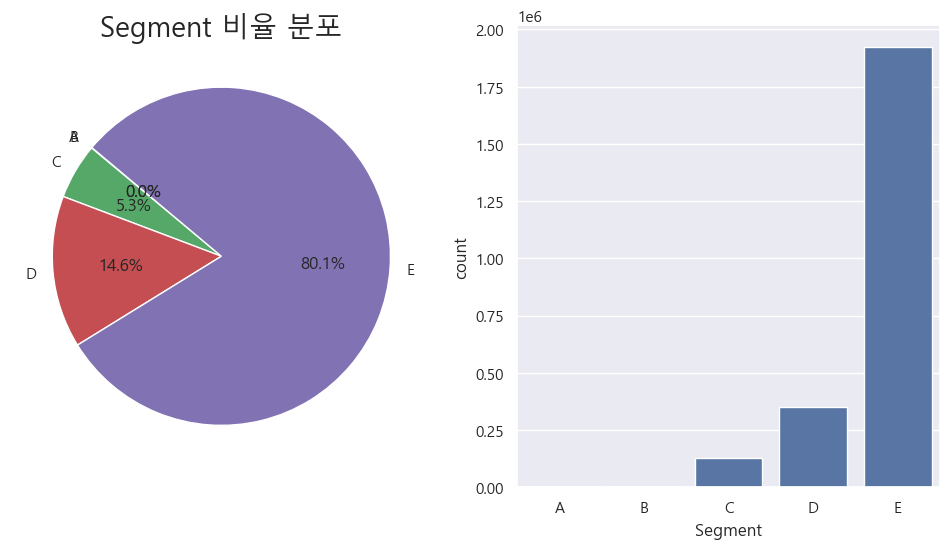

In [10]:
# Segment 개수
# Segment의 갯수 시각화하여 확인
plt.figure(figsize=(12,6))
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus": False},
        style='darkgrid')
# 파이차트 그리기
plt.subplot(1,2,1)
plt.pie(df['Segment'].value_counts().sort_index(), labels=df['Segment'].value_counts().sort_index().index, autopct='%1.1f%%', startangle=140)
plt.title("Segment 비율 분포", fontsize=20)

# count로 얼마나 있는지 확인하기
plt.subplot(1,2,2)
sns.countplot(data=df, x='Segment', order=sorted(df['Segment'].unique()))
plt.show()

- Segment의 균형이 상당히 불균형 하므로, 모델학습시 상당히 까다로울 가능성이 있을 것이다.

In [11]:
def corr_maker(df, filename= False, method = "pearson"):
    mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5}
    # 1. 데이터 복사 (원본 데이터프레임 보호)
    temp_df = df.copy()
    temp_df["Segment"] = temp_df["Segment"].map(mapping)
    # 2. 문자열 컬럼만 골라내기
    obj_cols = temp_df.select_dtypes(include=['object']).columns

    # 3. 문자열 컬럼만 factorize 적용
    for col in obj_cols:
        temp_df[col] = pd.factorize(temp_df[col])[0]

    # 4. 전체 상관관계 계산 (스피어먼 방식)
    corr_matrix = temp_df.corr(method = method)# method = spearman

    # 5. 특정 컬럼('Segment') 기준 추출
    target_col = 'Segment'
    if target_col in corr_matrix.columns:
        target_corr = corr_matrix[target_col].sort_values(ascending=False)
        result_series = target_corr.drop(target_col)
        
        # --- [추가된 부분: 파일 저장] ---
        if filename:
            with open(filename, 'w', encoding='utf-8') as f:
                f.write(f"[{target_col}] 기준 상관관계 순위 (Spearman):\n")
                f.write("-" * 50 + "\n")
                f.write(result_series.to_string())
                f.write("\n" + "-" * 50)
                print(f"결과가 {filename}에 저장되었습니다.")
        print(result_series)
        # -------------------------------
    else:
        print(f"'{target_col}' 컬럼이 데이터에 없습니다.")

In [12]:
# 만들어 놓은 corr파일을 읽어오는 함수
def read_corr(filename = False):
    if filename:
        f = open(filename, "r")
        Segment_corr = []
        temp = f.readline()
        temp = f.readline()

        while True:
            temp = f.readline()
            temp = [temp.split()[0], float(temp.split()[-1])]
            if str(temp[1]) == "nan":
                break
            else:
                Segment_corr.append(temp)
        f.close()
        return Segment_corr
    else:
        print("Please Enter filename")

In [13]:
# 주의 : 상관관계들이 모두 절대값이 된다.
# 상관관계를 정렬하는 함수
def sort_corr(corrs):
    new_corr = []
    for corr in corrs:
        new_corr.append([corr[0], abs(corr[1])])   
    new_corr = sorted(new_corr, key = lambda x:x[1], reverse = True)
    return new_corr

# 일정치 이상의 corr만 남기는 함수
def filter_high_corr(corrs, filter = 0.2):
    new_corr = []
    for corr in corrs:
        if (corr[1] >= filter) | (corr[1]<= -filter):
            new_corr.append(corr)
    return new_corr

In [14]:
# 파일을 만들어서 저장하는 함수
# corr_maker(df, filename = "Segment_Correlation_Spearman.txt")
# corr_maker(df, filename = "Segment_Correlation_Pearson", method = "pearson")

- 상관관계 확인후 해야할 것
    - 1. 상관관계 중 높은 것들을 확인하고, 높은것들 중 비슷한 것들 쳐내기.
        - 일단 0.2 이상인 것들을 기준으로 하자.
    - 2. select_type을 통해 데이터가 문자열로 이루어진 column들을 찾아 데이터를 시각화 및 상관관계를 재확인후 제거하기

In [15]:
# 2. column 중 문자열로 이루어진 column들
# object_list = list(df.select_dtypes(include = ['object']).columns)
# object_list

#### 상관관계를 확인하는 함수들

In [16]:
# 주의 : 두 함수의 형식이 다음과 같아야함! [['문자열', 1], ['문자열', 2]]
def compare(corr1, corr2):
    temp1 = []
    temp2 = []
    for name in corr1:
        temp1.append(name[0])
    for name in corr2:
        temp2.append(name[0])
    result = set(temp1) & set(temp2)
    print("공통으로 가지고 있지 않았던 요소들 : {}".format(list(set(temp1) - set(temp2)) + (list(set(temp2)- set(temp1)))))
    return list(result)

### 상관관계를 정리하고 비교하여 추출

In [17]:
Spearman_corr = read_corr(filename = "Segment_Correlation_Spearman.txt")
Spearman_corr = sort_corr(Spearman_corr)
Spearman_corr = filter_high_corr(Spearman_corr)
len(Spearman_corr)

230

In [18]:
Pearson_corr = read_corr(filename = "Segment_Correlation_Pearson")
Pearson_corr = sort_corr(Pearson_corr)
Pearson_corr = filter_high_corr(Pearson_corr)

In [19]:
common_name = compare(Pearson_corr, Spearman_corr)

공통으로 가지고 있지 않았던 요소들 : ['이용금액_체크_R6M', '최대이용금액_체크_R12M', '이용금액_R3M_체크', '잔액_현금서비스_B1M', '이용건수_체크_B0M', '마일_이용포인트_R3M', '포인트_마일리지_건별_B0M', '이용금액_체크_B0M', '할인금액_청구서_R3M', '마일_이용포인트_R12M', '이용건수_체크_R12M', 'RP건수_B0M', '포인트_마일리지_건별_R3M', '이용금액_할부_무이자_B0M', '이용건수_체크_R3M', '마일_적립포인트_R12M', '이용금액_체크_R3M', '이용건수_체크_R6M', '잔액_신판평균한도소진율_r6m', '이용후경과월_일시불', '포인트_이용포인트_R12M', '최종이용일자_기본', '잔액_신판평균한도소진율_r3m', '잔액_신판최대한도소진율_r3m', '_2순위쇼핑업종', '_1순위교통업종', '포인트_이용포인트_R3M', '이용개월수_결제일_R6M', '_3순위쇼핑업종', '이용후경과월_신용']


- 상관관계가 0.2 이상인 값들이 Spearman방식이든 Pearson이든 같다. 아무거나 하나 집어서 사용하자.

### 뽑아낸 리스트중, 겹치는 부분이 좀 많다! 이건 AI에게 넘겨서 연관성이 있는 부분들끼리 뭉치게 한 다음 txt파일로 만들어달라고 해보자.

In [20]:
if list(filter(lambda x: x.endswith('backup.txt'), os.listdir())) == []:
    print("파일을 만드러용")
    f = open("corr_Name.txt","w")
    f.write("상관관계가 0.2 이상인 것들의 리스트\n")
    f.write("-"* 50 + "\n")
    for name in common_name:
        f.write(name + "\n")
    f.close()

### 파일을 넘겨받고, 이제 연관성 있는 부분들을 뭉치게 한 파일이 되었다.
 - 저장은 corr_Name_backup.txt로 저장해두었음

In [21]:
# 데이터프레임에서 파라미터를 입력하면 그 파라미터가 포함된 column들을 가져와 새로운 데이터프레임을 반환함
# 연관성 있는 column들을 얻어오기 위해서 사용한다.
def find_R(df, param1):
    columns = list(df.columns)
    new_columns = []
    for column in columns:
        if param1 in column:
            new_columns.append(column)
    return pd.DataFrame(df[new_columns])

- 함수로 데이터를 뽑아내고, common name과 동일한 column을 집합으로 확인한뒤 리스트 변환하여 가져오기

In [22]:
# corr_dict 파일 로드 확인
print("현재 working directory:", os.getcwd())
print("\ncorr_dict 로드 성공!")
print("사용 가능한 카테고리:", list(corr_dict.keys()))
print("\n예시 - 카테고리 1의 변수들:")
print(corr_dict[1])

현재 working directory: c:\Users\Administrator\github\Credit-Card-Segment\LGW

corr_dict 로드 성공!
사용 가능한 카테고리: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]

예시 - 카테고리 1의 변수들:
['이용금액_온라인_R6M', '이용금액_온라인_R3M', '이용금액_온라인_B0M', '이용금액_오프라인_R6M', '이용금액_오프라인_R3M', '이용금액_오프라인_B0M', '이용금액_간편결제_R6M', '이용금액_간편결제_R3M', '이용금액_간편결제_B0M']


In [23]:
new_column_list = []
for i in range(1,37):
    new_column_list = new_column_list + corr_dict[i]
new_column_list

['이용금액_온라인_R6M',
 '이용금액_온라인_R3M',
 '이용금액_온라인_B0M',
 '이용금액_오프라인_R6M',
 '이용금액_오프라인_R3M',
 '이용금액_오프라인_B0M',
 '이용금액_간편결제_R6M',
 '이용금액_간편결제_R3M',
 '이용금액_간편결제_B0M',
 '이용금액_일시불_R12M',
 '이용금액_일시불_R6M',
 '이용금액_일시불_R3M',
 '이용금액_일시불_B0M',
 '이용금액_R3M_신용체크',
 '이용금액_R3M_신용',
 '이용금액_R3M_신용_가족',
 '이용금액_체크_R12M',
 '이용금액_할부_R12M',
 '이용금액_할부_R6M',
 '이용금액_할부_R3M',
 '이용금액_할부_B0M',
 '이용금액_할부_무이자_R12M',
 '이용금액_할부_무이자_R6M',
 '이용금액_할부_무이자_R3M',
 '이용금액_페이_온라인_R6M',
 '이용금액_페이_온라인_R3M',
 '이용금액_페이_온라인_B0M',
 '이용금액_CA_R12M',
 '이용금액_CA_R6M',
 '이용금액_CA_R3M',
 '이용금액_CA_B0M',
 '이용금액_해외',
 '이용건수_온라인_R6M',
 '이용건수_온라인_R3M',
 '이용건수_온라인_B0M',
 '이용건수_오프라인_R6M',
 '이용건수_오프라인_R3M',
 '이용건수_오프라인_B0M',
 '이용건수_간편결제_R3M',
 '이용건수_간편결제_B0M',
 '이용건수_간편결제_R6M',
 '이용건수_일시불_R12M',
 '이용건수_일시불_R6M',
 '이용건수_일시불_R3M',
 '이용건수_일시불_B0M',
 '이용건수_할부_R12M',
 '이용건수_할부_R6M',
 '이용건수_할부_R3M',
 '이용건수_할부_B0M',
 '이용건수_할부_무이자_R12M',
 '이용건수_할부_무이자_R6M',
 '이용건수_할부_무이자_R3M',
 '이용건수_할부_무이자_B0M',
 '이용건수_신판_R12M',
 '이용건수_신판_R6M',
 '이용건수_신판_R3M',
 '이용건수_신판_B0M',


In [24]:
fee_df = df[["Segment"] + new_column_list]

In [25]:
R6M = pd.concat([fee_df["Segment"], find_R(fee_df, "R6M")], axis=1)
corr_maker(R6M)

이용개월수_일시불_R6M      -0.208679
이용개월수_신판_R6M       -0.209428
이용개월수_신용_R6M       -0.215954
이용개월수_오프라인_R6M     -0.216505
이용개월수_전체_R6M       -0.232901
이용개월수_CA_R6M       -0.244660
이용건수_CA_R6M        -0.247865
이용건수_할부_무이자_R6M    -0.254382
이용개월수_할부_무이자_R6M   -0.255036
이용개월수_할부_R6M       -0.255660
이용건수_할부_R6M        -0.257437
이용금액_CA_R6M        -0.275540
이용금액_할부_R6M        -0.289399
이용금액_할부_무이자_R6M    -0.291934
이용개월수_간편결제_R6M     -0.313498
이용개월수_페이_온라인_R6M   -0.318474
이용개월수_온라인_R6M      -0.321242
이용금액_간편결제_R6M      -0.331895
이용건수_페이_온라인_R6M    -0.338645
이용건수_간편결제_R6M      -0.338993
이용금액_온라인_R6M       -0.351423
이용금액_페이_온라인_R6M    -0.358309
이용건수_온라인_R6M       -0.367225
이용건수_일시불_R6M       -0.429096
이용건수_신판_R6M        -0.432737
이용건수_신용_R6M        -0.436528
이용건수_오프라인_R6M      -0.450232
이용금액_오프라인_R6M      -0.538775
이용금액_일시불_R6M       -0.568893
청구금액_R6M           -0.597904
Name: Segment, dtype: float64


In [26]:
R6M.columns

Index(['Segment', '이용금액_온라인_R6M', '이용금액_오프라인_R6M', '이용금액_간편결제_R6M',
       '이용금액_일시불_R6M', '이용금액_할부_R6M', '이용금액_할부_무이자_R6M', '이용금액_페이_온라인_R6M',
       '이용금액_CA_R6M', '이용건수_온라인_R6M', '이용건수_오프라인_R6M', '이용건수_간편결제_R6M',
       '이용건수_일시불_R6M', '이용건수_할부_R6M', '이용건수_할부_무이자_R6M', '이용건수_신판_R6M',
       '이용건수_페이_온라인_R6M', '이용건수_CA_R6M', '이용건수_신용_R6M', '이용개월수_전체_R6M',
       '이용개월수_신용_R6M', '이용개월수_할부_R6M', '이용개월수_할부_무이자_R6M', '이용개월수_신판_R6M',
       '이용개월수_일시불_R6M', '이용개월수_CA_R6M', '이용개월수_간편결제_R6M', '이용개월수_페이_온라인_R6M',
       '이용개월수_온라인_R6M', '이용개월수_오프라인_R6M', '청구금액_R6M'],
      dtype='str')

In [27]:
R6M["이용금액_할부_R6M"].compare(R6M["이용금액_할부_무이자_R6M"])

,self,other
3,16531.0,8538.0
16,6915.0,2116.0
22,24696.0,11038.0
25,49351.0,25003.0
31,8157.0,5551.0
...,...,...
399796,24858.0,0.0
399863,47028.0,20596.0
399962,44821.0,17387.0
399987,28908.0,23532.0


## AI에게 받은 추천 항목


### **[통합 카테고리별 핵심 변수 추천 리스트]**

#### **1. 종합 소비 규모 및 활성도 (기존 1, 2, 4, 5, 6, 8, 23)**

* **설명**: 전체적인 씀씀이와 얼마나 자주 카드를 쓰는지 보여주는 지표입니다.
* **추천 항목**:
* `이용금액_일시불_R6M`: 단기 변동성이 적고 전반적인 소비 능력을 가장 잘 보여줍니다. 


* `이용건수_신판_R6M`: 사용자가 카드를 얼마나 생활화해서 쓰는지 보여주는 핵심 지표입니다. 


* `최대이용금액_일시불_R12M`: 이 사람의 최대 가처분 소득 수준을 가늠할 수 있습니다. 





#### **2. 할부 및 현금서비스(CA) 이용 행태 (기존 3, 7, 13, 15, 16, 17, 30, 31)**

* **설명**: 고가 물품 구매나 급전 필요 여부를 파악하며, 부채 성격이 강한 지표입니다.
* **추천 항목**:
* `잔액_할부_B0M`: 현재 갚아야 할 할부 총액으로, 미래 지출 부담을 나타냅니다. 


* `이용금액_CA_R6M`: 현금서비스 이용 패턴은 신용도와 밀접한 관련이 있습니다. 


* `이용후경과월_할부`: 최근에 할부를 이용했는지 여부로 구매 활성도를 체크합니다. 





#### **3. 자산 규모 및 한도 여유도 (기존 11, 12, 14, 26)**

* **설명**: 계좌의 잔고 수준과 부여된 한도를 얼마나 꽉 채워 쓰는지 보여줍니다.
* **추천 항목**:
* `평잔_6M`: 6개월간의 평균 잔액은 가장 안정적인 자산 지표입니다. 


* `잔액_신판최대한도소진율_r6m`: 한도에 육박해서 쓰고 있다면 자금 사정이 타이트함을 의미합니다. 


* `카드이용한도금액`: 카드사가 평가하는 이 사람의 객관적인 신용 등급의 결과물입니다. 





#### **4. 청구 및 연체 관리 (기존 18, 19)**

* **설명**: 실제 납부해야 할 금액과 상환 능력을 보여줍니다.
* **추천 항목**:
* `청구금액_R6M`: 실제 결제일에 나가는 돈의 평균치입니다. 


* `연체입금원금_B0M`: 과거가 아닌 '현재'의 상환 리스크를 파악하는 직결 지표입니다. 





#### **5. 소비 업종 및 성향 (기존 20, 21, 22, 27, 28, 29, 36)**

* **설명**: 어디에 돈을 주로 쓰는지에 따라 라이프스타일을 분류합니다.
* **추천 항목**:
* `_1순위업종_이용금액`: 가장 지출이 큰 분야를 통해 주 소비층을 구분합니다. 


* `이용가맹점수`: 소비의 다양성을 보여주며 활동성을 나타냅니다. 





#### **6. 고객 충성도 및 카드 소지 현황 (기존 9, 10, 24, 25, 32)**

* **설명**: 얼마나 오래 거래했는지와 카드를 몇 장이나 가지고 있는지 보여줍니다.
* **추천 항목**:
* `입회경과개월수_신용`: 거래 기간이 길수록 데이터의 신뢰도가 높고 우량 고객일 확률이 높습니다. 


* `유효카드수_신용체크`: 실제 사용 가능한 카드 수는 주거래 은행 여부를 판단하게 합니다. 





#### **7. 혜택 및 부가 서비스 (기존 33, 34, 35)**

* **설명**: 할인이나 포인트를 얼마나 챙기는지, 체리피커 성향이 있는지 파악합니다.
* **추천 항목**:
* `혜택수혜금액_R3M`: 카드사 입장에서의 수익성 및 고객의 혜택 민감도를 보여줍니다. 


* `포인트_마일리지_환산_B0M`: 가용 현금 외의 보조 결제 수단 보유량을 뜻합니다. 





---

### **💡 분석 팁**

* **R6M(6개월 평균) vs B0M(당월)**: 모델의 안정성을 위해서는 **R6M**을 주 변수로 쓰시고, 최근의 급격한 변화를 감지하고 싶을 때만 **B0M**을 보조로 쓰시는 것이 좋습니다. 


* **중복 제거**: '이용금액'과 '이용건수'는 서로 상관관계가 매우 높으므로, 둘 중 하나(주로 **금액**)만 선택해도 충분합니다. 



이 리스트를 기반으로 변수를 줄여보시면 모델이 훨씬 가볍고 정확해질 것입니다. 추가로 특정 목적(예: 연체 예측 등)이 생기시면 그에 맞춰 다시 선별해 드릴 수 있습니다.

## 위 사항들을 기반으로, 칼럼 16개를 뽑아서 사용해보자.

In [28]:
# 먼저 다음과 같이, 16개의 컬럼을 데이터프레임에서 뽑아낸다.
selected_columns = [
    '이용금액_일시불_R6M',
    '최대이용금액_일시불_R12M',
    '잔액_할부_B0M',
    '이용금액_CA_R6M',
    '이용후경과월_할부',
    '평잔_6M',
    '잔액_신판최대한도소진율_r6m',
    '카드이용한도금액',
    '청구금액_R6M',
    '연체입금원금_B0M',
    '_1순위업종_이용금액',
    '이용가맹점수',
    '입회경과개월수_신용',
    '유효카드수_신용체크',
    '혜택수혜금액_R3M',
    '포인트_마일리지_환산_B0M'
]

- heatmap으로 현황 확인하기

Text(0.5, 1.0, 'AI가 뽑아준 컬럼들의 heatmap')

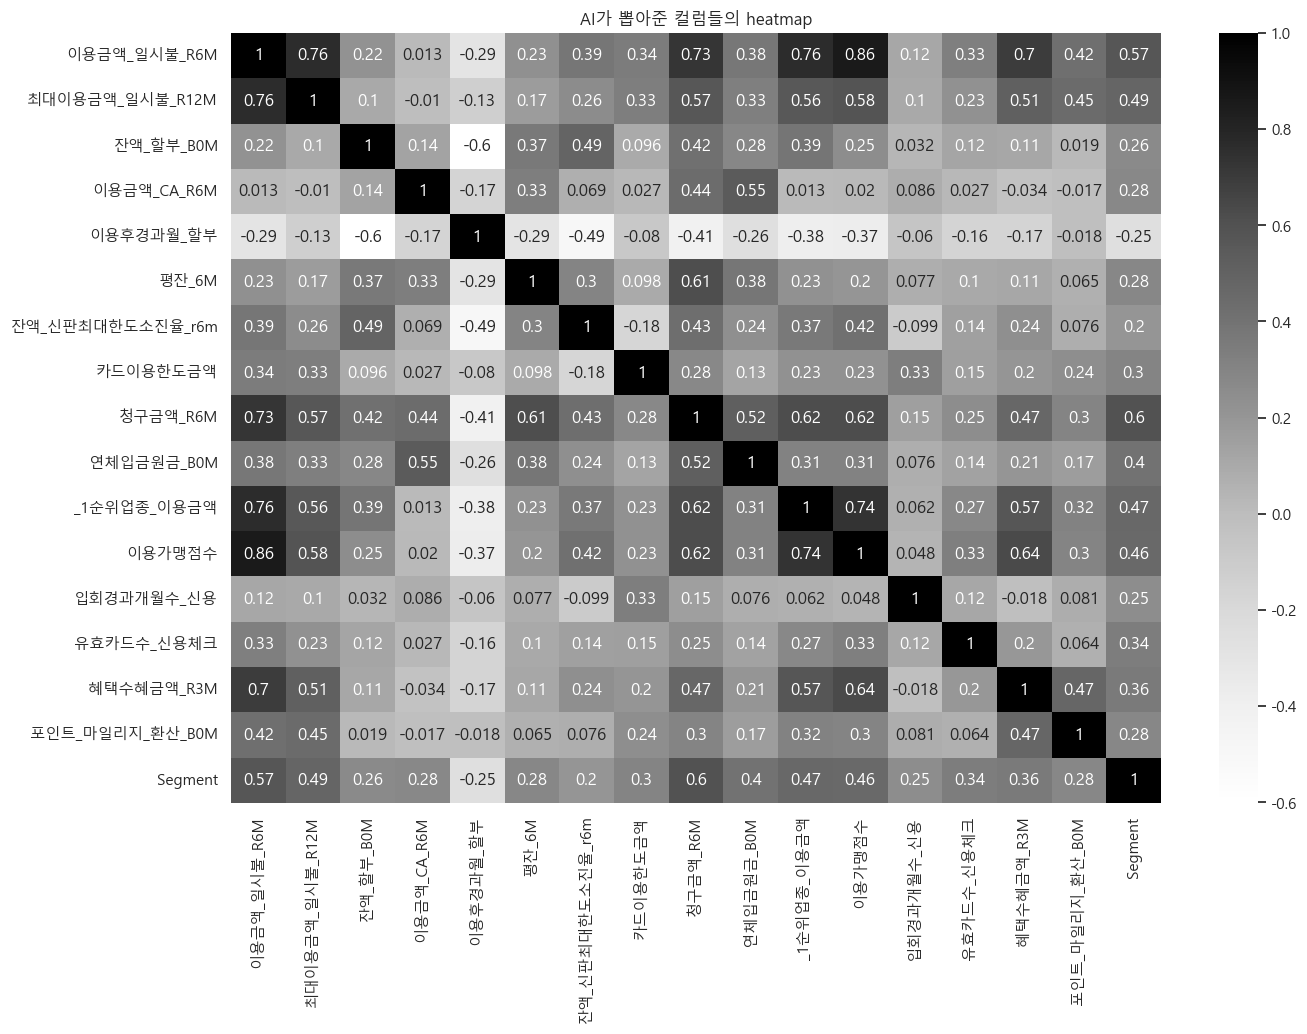

In [29]:
selected_df = df[selected_columns + ["Segment"]]
mapping = {'A': 4, 'B': 3, 'C': 2, 'D': 1, 'E': 0}
selected_df["Segment"] = selected_df["Segment"].map(mapping)
plt.figure(figsize =(15,10))
sns.heatmap(data = selected_df.corr(), annot = True,cmap = "Greys")
plt.title(label = "AI가 뽑아준 컬럼들의 heatmap")

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2948\3897464012.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['E', 'D', 'C', 'B', 'A'])


[Text(0, 0, 'E'),
 Text(1, 0, 'D'),
 Text(2, 0, 'C'),
 Text(3, 0, 'B'),
 Text(4, 0, 'A')]

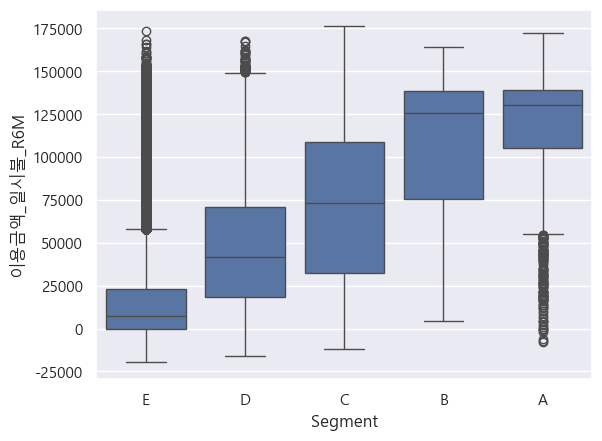

In [30]:
ax = sns.boxplot(data = selected_df, x = "Segment", y = "이용금액_일시불_R6M")
ax.set_xticklabels(['E', 'D', 'C', 'B', 'A'])

- E부분에 이상치가 많음을 확인가능,
- A로 갈수록 중간값이 높아지는것을 확인 가능

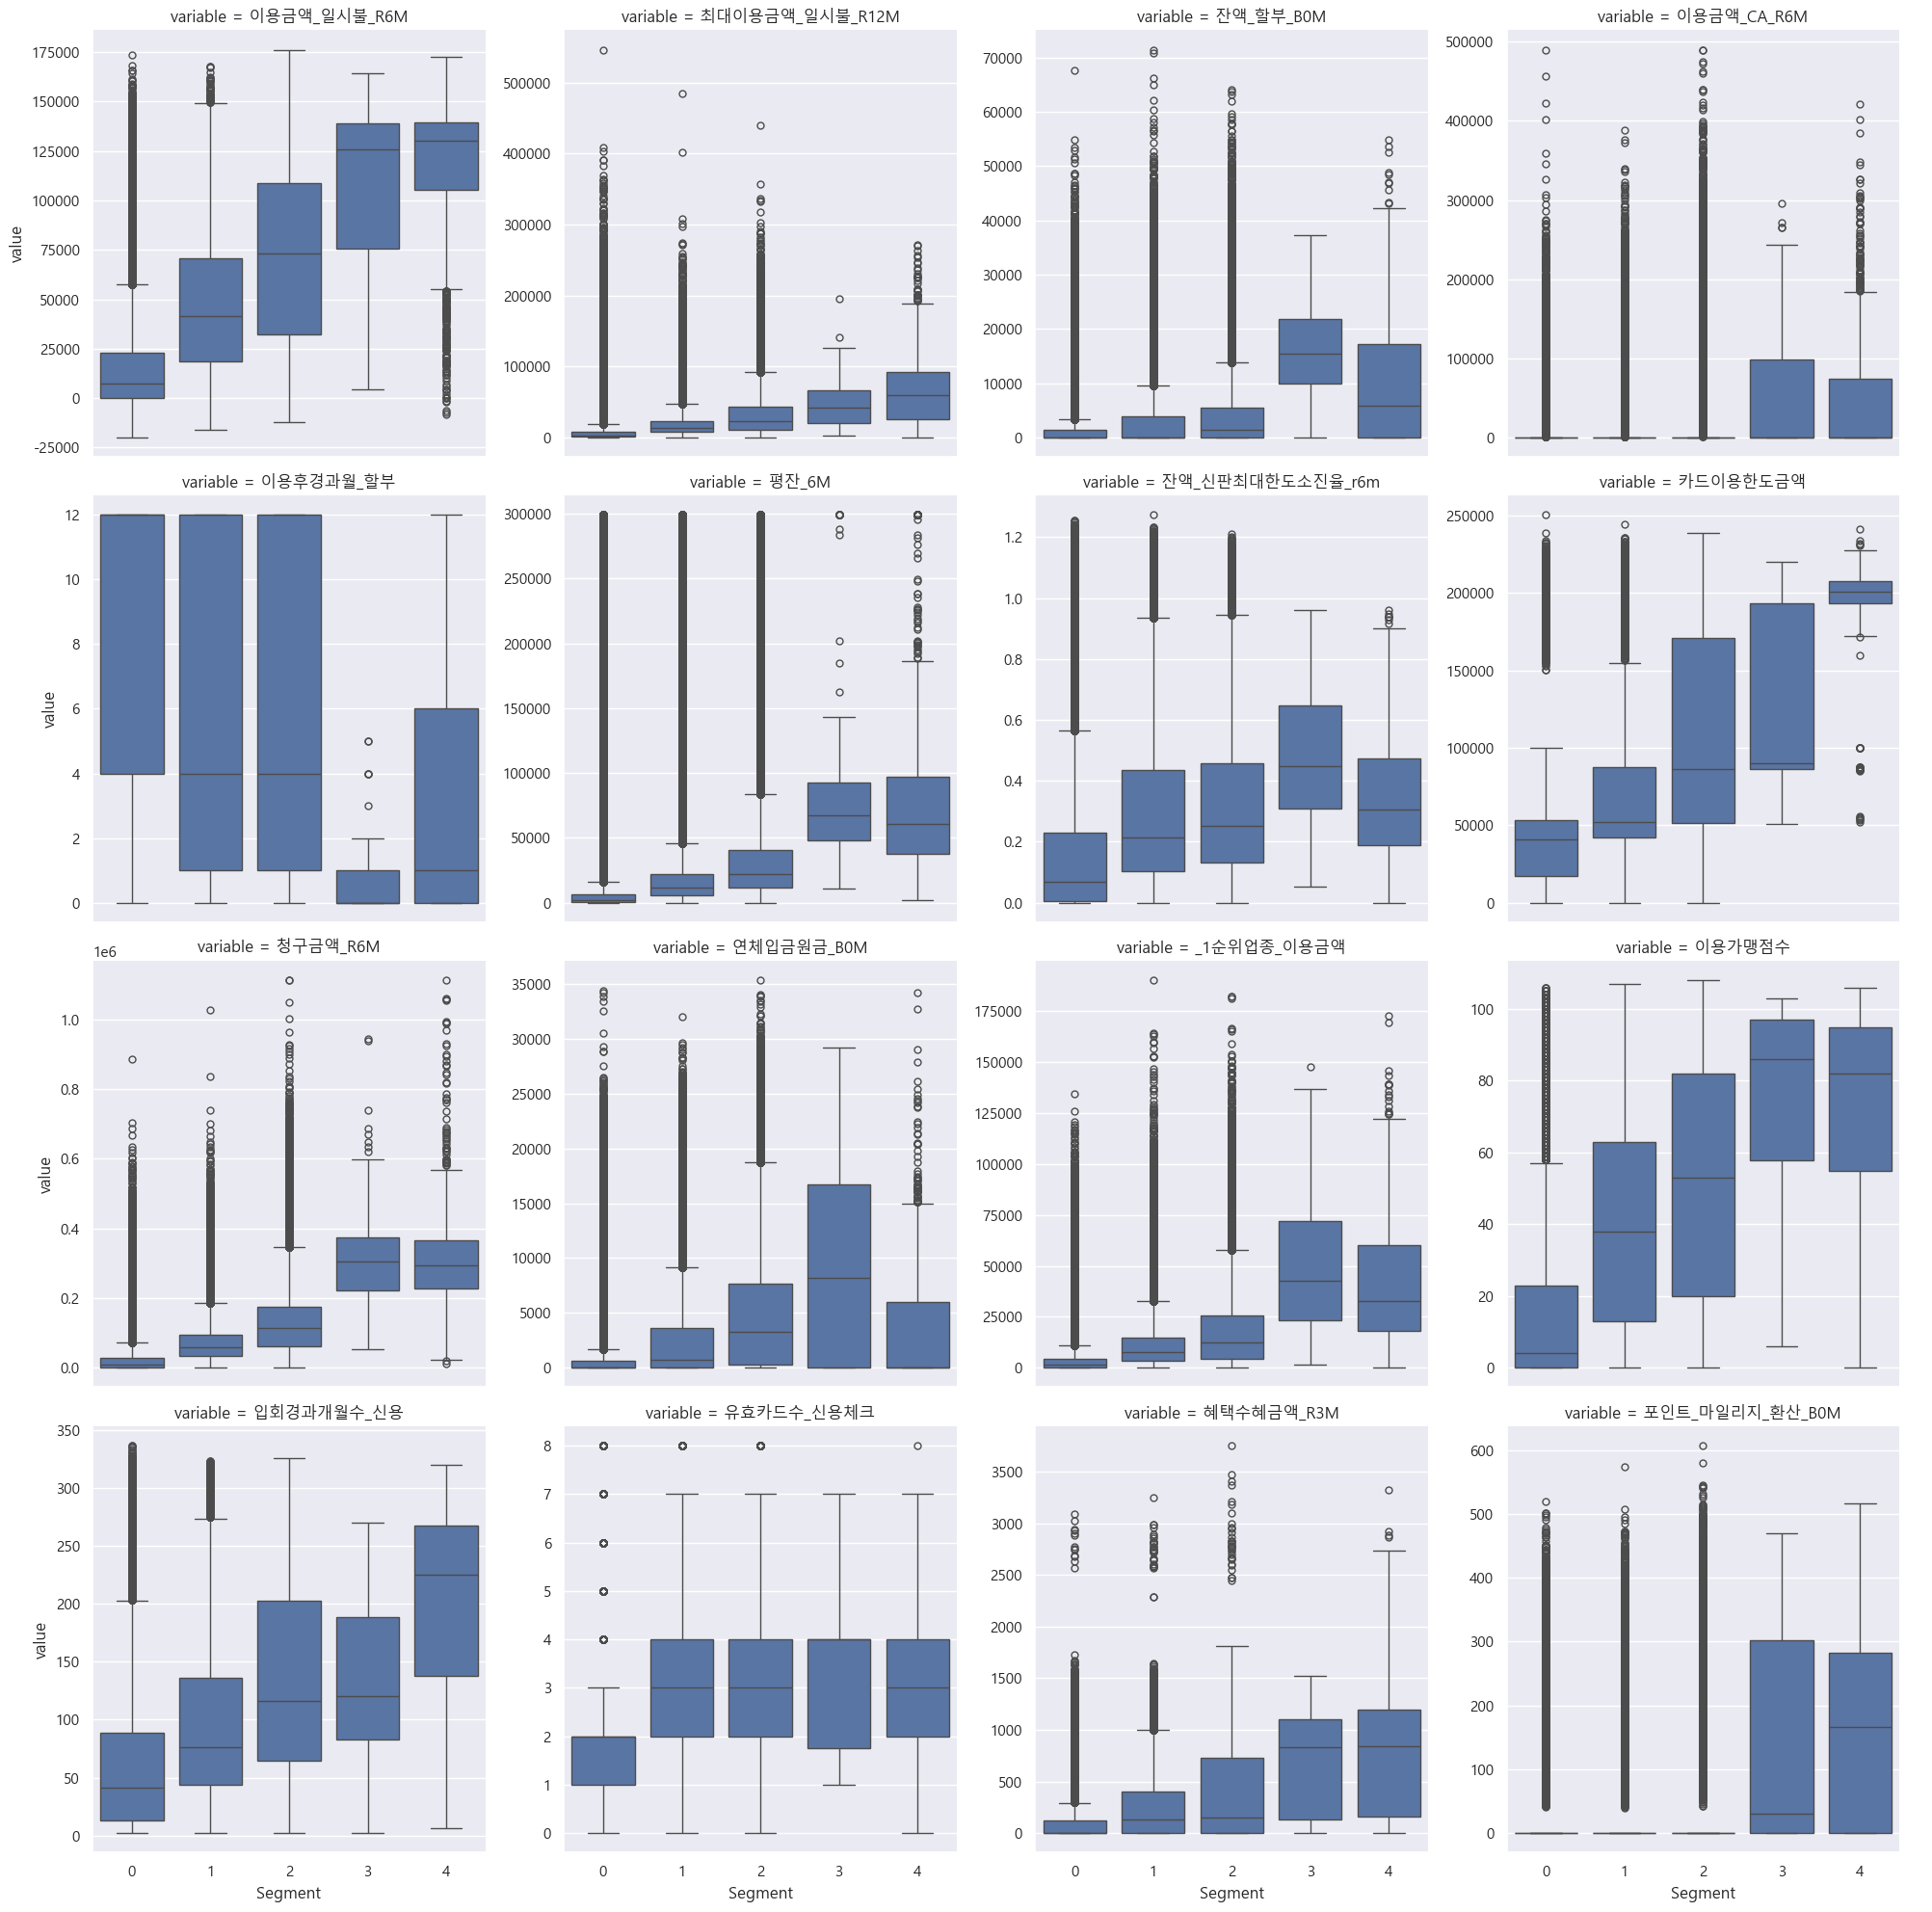

In [31]:
sns.catplot(data = selected_df.melt(id_vars = "Segment", value_vars= selected_columns), x = "Segment", y = "value", col = "variable", kind= "box", col_wrap= 4, sharey=False)

* **boxplot 사용 후 유의미해보이는 결과**
    - 유의미한 결과를 확인 가능한 부분 : 이용금액_일시불_R6M, 최대이용금액_일시불_R12M, 청구금액_R6M

    - 이상치 : 문제는 이상치인데, 이상치에 대해서 해석을 해보자면 잔액이나 결제는 많지만, 다른 요소에서 이상치가 생길 요소가 있을 가능성이 높다. 이 부분을 찾는다면 이상치를 처리하지 않아도 될것 같은데... 피처 엔지니어링때 이상치를 0.5로 박아버릴까??

In [32]:
def get_outlier_percentage(df):
    # 수치형 데이터만 선택
    numeric_df = df.select_dtypes(include=['number'])
    
    # 결과를 담을 딕셔너리
    outlier_info = {}
    
    for col in numeric_df.columns:
        Q1 = numeric_df[col].quantile(0.25)
        Q3 = numeric_df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # 이상치 기준 설정 (보통 1.5를 사용합니다)
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # 이상치 개수 계산
        outliers = numeric_df[(numeric_df[col] < lower_bound) | (numeric_df[col] > upper_bound)]
        percentage = (len(outliers) / len(numeric_df)) * 100
        
        outlier_info[col] = round(percentage, 2)
    
    # 결과를 데이터프레임으로 변환하여 보기 좋게 출력
    result_df = pd.DataFrame(list(outlier_info.items()), columns=['Column', 'Outlier_Percentage (%)'])
    return result_df# .sort_values(by='Outlier_Percentage (%)', ascending=False)
display(get_outlier_percentage(selected_df))

,Column,Outlier_Percentage (%)
0,이용금액_일시불_R6M,6.21
1,최대이용금액_일시불_R12M,7.45
2,잔액_할부_B0M,10.52
3,이용금액_CA_R6M,7.79
4,이용후경과월_할부,0.00
5,평잔_6M,10.45
6,잔액_신판최대한도소진율_r6m,6.69
7,카드이용한도금액,6.48
8,청구금액_R6M,7.28
9,연체입금원금_B0M,13.56


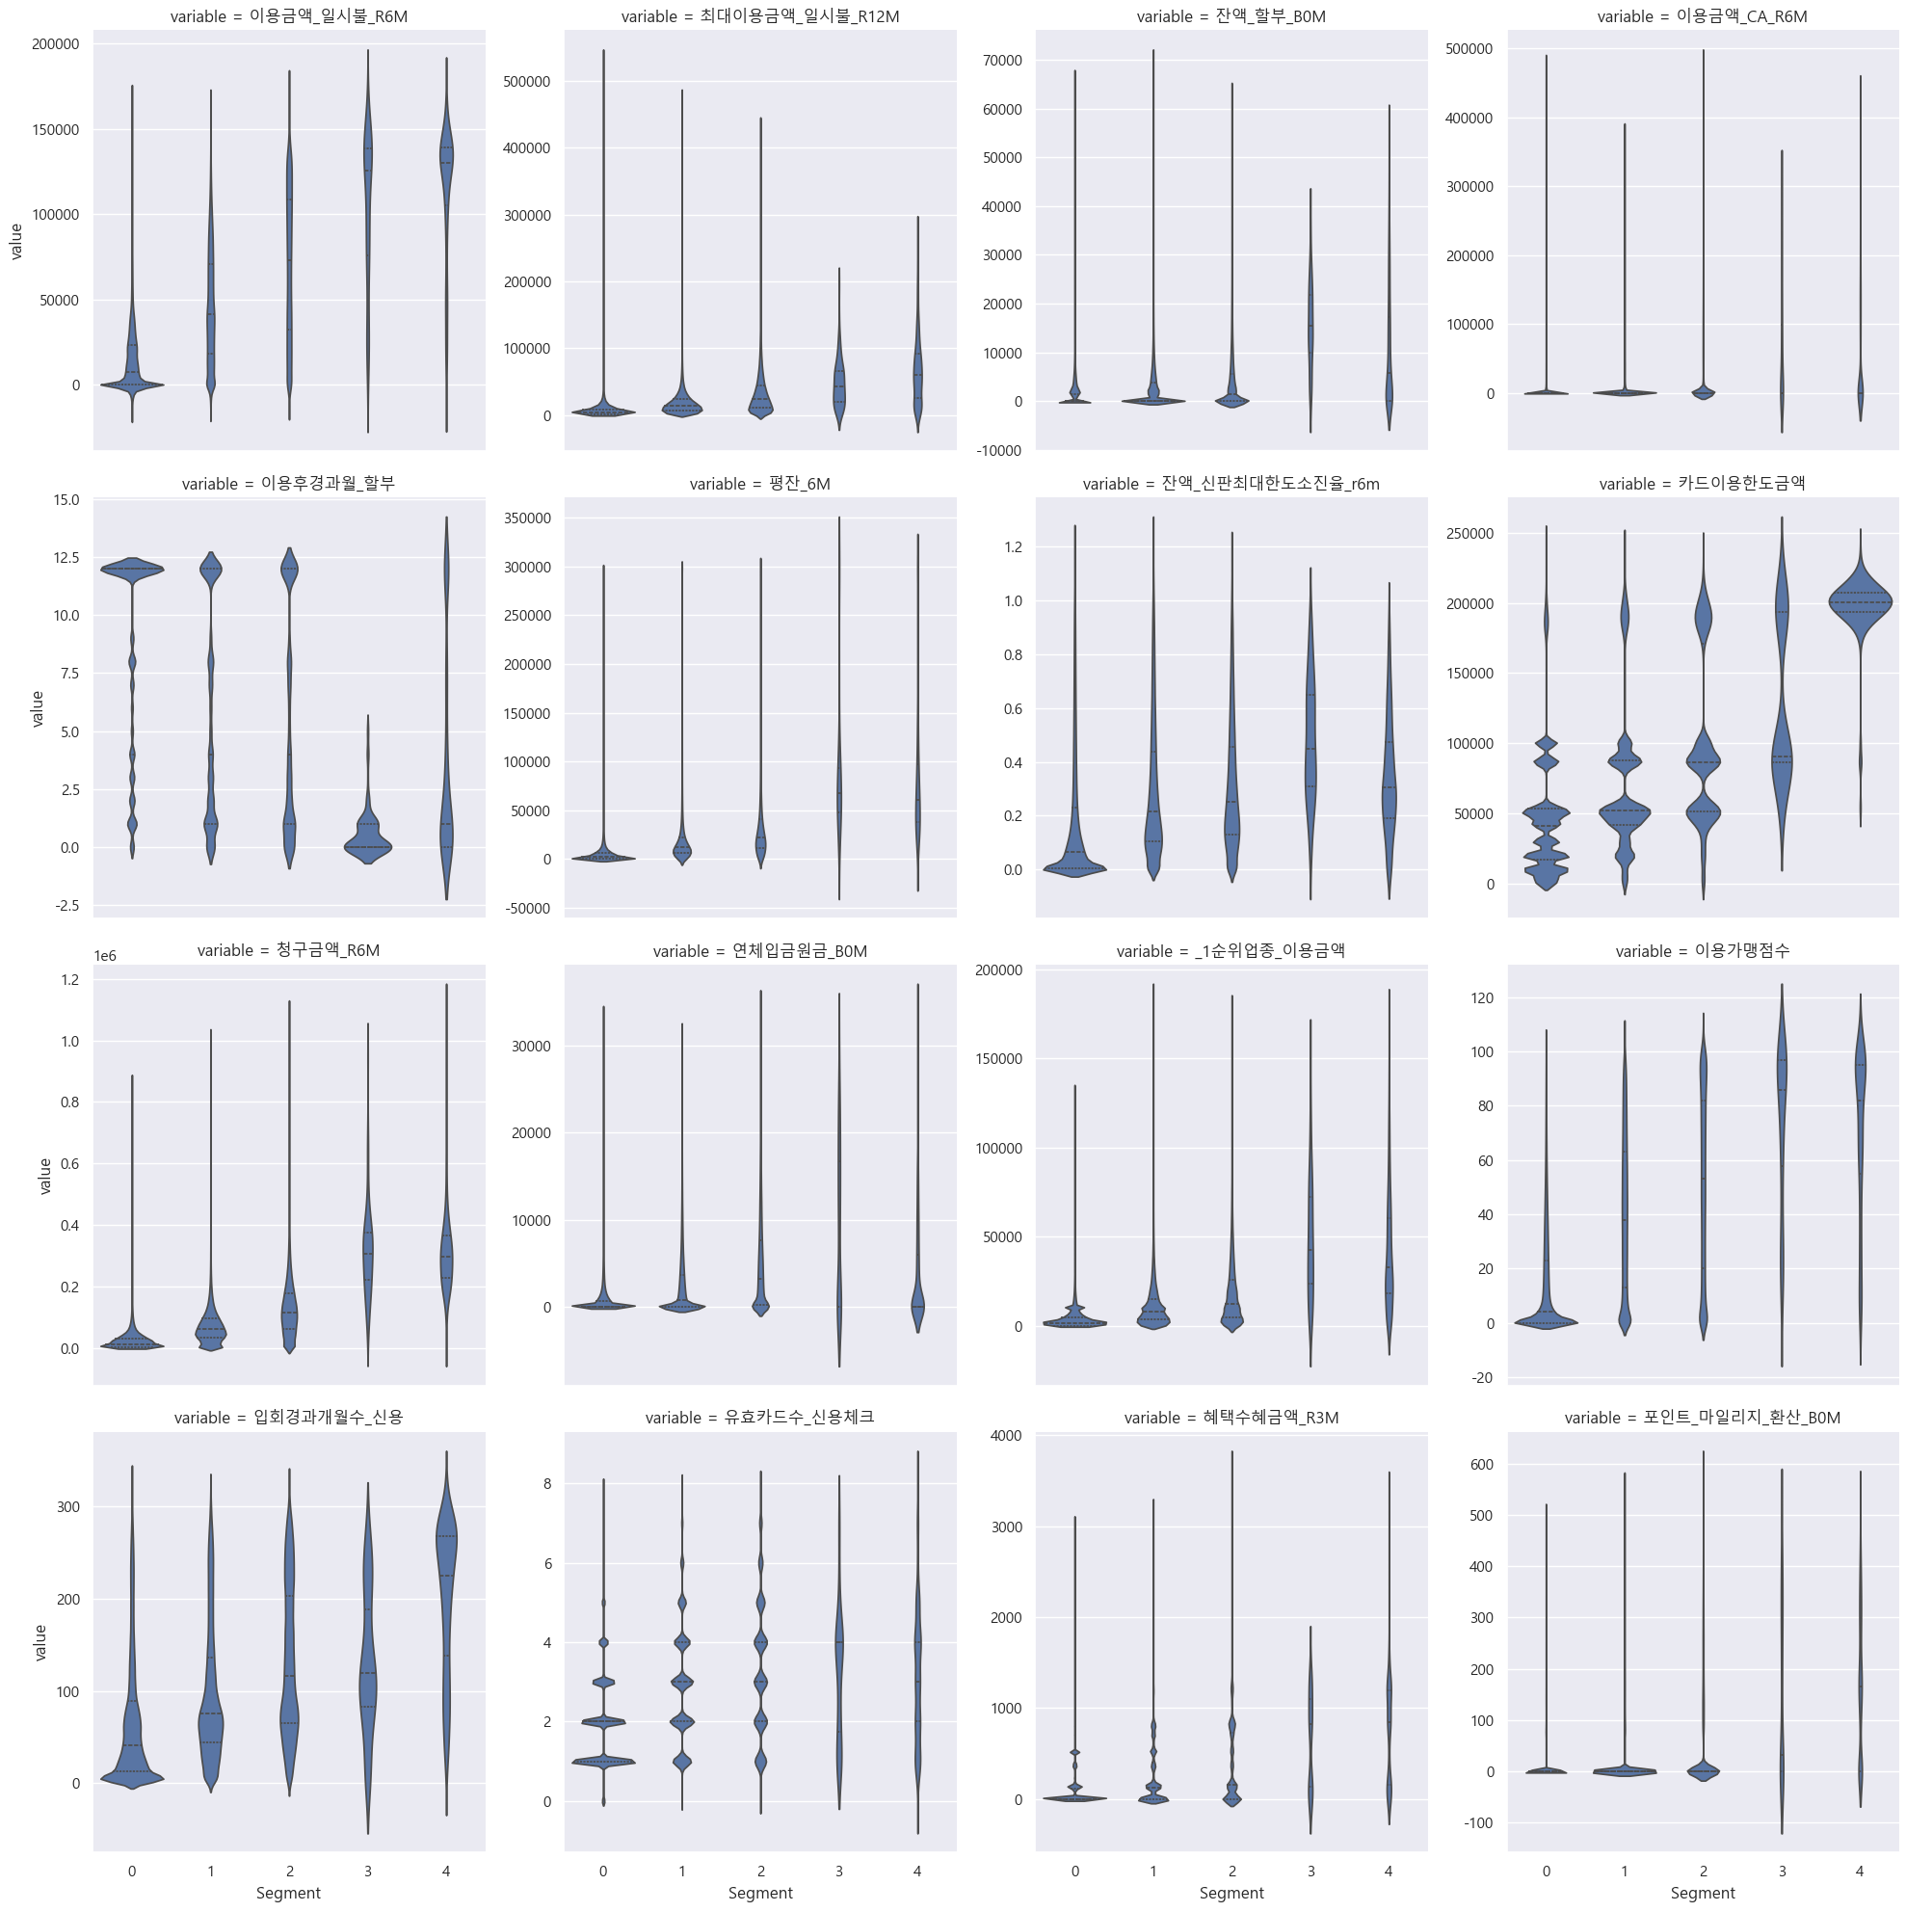

In [33]:
df_melted = selected_df.melt(id_vars = "Segment", value_vars= selected_columns)
sns.catplot(
    data= df_melted, x="Segment", y="value", col="variable",
    kind="violin",  # 바이올린 형태로 변경
    col_wrap=4, sharey=False,
    inner="quartile" # 바이올린 안에 점선으로 사분위수 표시
)

### 모델링 부분


In [34]:
# train 데이터 준비
train = selected_df.copy()
X_train = train.drop('Segment', axis=1)
y_train = train['Segment']

# test 데이터 준비 (샘플로 train에서 분리)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify = y_train)

In [35]:
# CatBoost
cat_model = CatBoostClassifier( task_type='GPU',      # CPU에서 GPU로 변경
                                devices='0',          # 사용할 GPU 번호 (보통 0번)
                                iterations=1000,
                                verbose=100)
cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict(X_test)
print("CatBoost Accuracy:", accuracy_score(y_test, cat_pred))
print("CatBoost F1:", f1_score(y_test, cat_pred, average='weighted'))

Learning rate set to 0.303443
0:	learn: 0.9024388	total: 84.2ms	remaining: 1m 24s
100:	learn: 0.3428280	total: 1.72s	remaining: 15.3s
200:	learn: 0.3363372	total: 3.3s	remaining: 13.1s
300:	learn: 0.3320440	total: 4.86s	remaining: 11.3s
400:	learn: 0.3284381	total: 6.37s	remaining: 9.51s
500:	learn: 0.3256335	total: 7.82s	remaining: 7.79s
600:	learn: 0.3226793	total: 9.27s	remaining: 6.15s
700:	learn: 0.3202112	total: 10.7s	remaining: 4.57s
800:	learn: 0.3177819	total: 12.2s	remaining: 3.02s
900:	learn: 0.3155673	total: 13.6s	remaining: 1.5s
999:	learn: 0.3134528	total: 15.1s	remaining: 0us
CatBoost Accuracy: 0.8705604166666666
CatBoost F1: 0.8618608115079067


In [36]:
# XGBoost
xgb_model = XGBClassifier(
                        tree_method='hist',  # GPU 사용을 위한 히스토그램 기반 알고리즘
                         device='cuda',       # GPU 장치 지정 (NVIDIA 기준)
                        n_estimators=100
)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))
print("XGBoost F1:", f1_score(y_test, xgb_pred, average='weighted'))

XGBoost Accuracy: 0.8666291666666667
XGBoost F1: 0.8576342906190025


In [37]:
# LightGBM
lgb_model = LGBMClassifier(device='gpu',        # 핵심 설정: 'cpu'에서 'gpu'로 변경
                            gpu_platform_id=0,   # 보통 0번
                            gpu_device_id=0,     # 보통 0번
                            n_estimators=1000,  
                            learning_rate=0.05)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)
print("LightGBM Accuracy:", accuracy_score(y_test, lgb_pred))
print("LightGBM F1:", f1_score(y_test, lgb_pred, average='weighted'))

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3443
[LightGBM] [Info] Number of data points in the train set: 1920000, number of used features: 16
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 13 dense feature groups (29.30 MB) transferred to GPU in 0.014384 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.222076
[LightGBM] [Info] Start training from score -1.927457
[LightGBM] [Info] Start training from score -2.934402
[LightGBM] [Info] Start training from score -9.722904
[LightGBM] [Info] Start training from score -7.811109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [38]:
# 앙상블
from sklearn.ensemble import VotingClassifier
ensemble = VotingClassifier(estimators=[('cat', cat_model), 
                                        ('xgb', xgb_model),
                                        ('lgb', lgb_model)], 
                                        voting='soft')
ensemble.fit(X_train, y_train)
ensemble_pred = ensemble.predict(X_test)
print("Ensemble Accuracy:", accuracy_score(y_test, ensemble_pred))
print("Ensemble F1:", f1_score(y_test, ensemble_pred, average='weighted'))

Learning rate set to 0.303443
0:	learn: 0.9024389	total: 15ms	remaining: 15s
100:	learn: 0.3428279	total: 1.46s	remaining: 13s
200:	learn: 0.3363372	total: 2.86s	remaining: 11.4s
300:	learn: 0.3320439	total: 4.29s	remaining: 9.96s
400:	learn: 0.3284381	total: 5.74s	remaining: 8.58s
500:	learn: 0.3256335	total: 7.18s	remaining: 7.15s
600:	learn: 0.3226793	total: 8.62s	remaining: 5.72s
700:	learn: 0.3202112	total: 10s	remaining: 4.28s
800:	learn: 0.3177821	total: 11.5s	remaining: 2.85s
900:	learn: 0.3155674	total: 12.9s	remaining: 1.42s
999:	learn: 0.3134527	total: 14.4s	remaining: 0us
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3443
[LightGBM] [Info] Number of data points in the train set: 1920000, number of used features: 16
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU progra

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# CatBoost 하이퍼파라미터 튜닝
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'verbose': 0,
        'task_type': 'GPU',
        'devices': '0'
    }
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    return f1_score(y_test, pred, average='weighted')

study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=50)
print("Best CatBoost params:", study_cat.best_params)
print("Best CatBoost score:", study_cat.best_value)

[I 2026-02-05 15:13:42,137] A new study created in memory with name: no-name-6cfe2da4-43f7-4edb-b2a8-53667deda440
[I 2026-02-05 15:13:45,138] Trial 0 finished with value: 0.8510887640599033 and parameters: {'iterations': 150, 'depth': 5, 'learning_rate': 0.09657737897987104, 'l2_leaf_reg': 3.796425926955534, 'border_count': 160}. Best is trial 0 with value: 0.8510887640599033.
[I 2026-02-05 15:13:49,787] Trial 1 finished with value: 0.8557397619036228 and parameters: {'iterations': 273, 'depth': 6, 'learning_rate': 0.17110500211708762, 'l2_leaf_reg': 6.316022206220212, 'border_count': 92}. Best is trial 1 with value: 0.8557397619036228.
[I 2026-02-05 15:14:08,675] Trial 2 finished with value: 0.8641976230194482 and parameters: {'iterations': 954, 'depth': 7, 'learning_rate': 0.24585855672577758, 'l2_leaf_reg': 2.290489973078518, 'border_count': 253}. Best is trial 2 with value: 0.8641976230194482.
[I 2026-02-05 15:14:13,680] Trial 3 finished with value: 0.8557008345648179 and parameter

In [ ]:
# XGBoost 하이퍼파라미터 튜닝
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'device': 'cuda'
    }
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    return f1_score(y_test, pred, average='weighted')

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=50)
print("Best XGBoost params:", study_xgb.best_params)
print("Best XGBoost score:", study_xgb.best_value)


In [ ]:
# LightGBM 하이퍼파라미터 튜닝
def objective_lgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }
    model = LGBMClassifier(**params)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    return f1_score(y_test, pred, average='weighted')

study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=50)
print("Best LightGBM params:", study_lgb.best_params)
print("Best LightGBM score:", study_lgb.best_value)

In [ ]:
# Optuna 튜닝된 모델로 최종 학습 및 예측
# CatBoost 최적 모델
best_cat_params = study_cat.best_params
best_cat_params['verbose'] = 0
best_cat_params['task_type'] = 'GPU'
best_cat_params['devices'] = '0'
cat_model_best = CatBoostClassifier(**best_cat_params)
cat_model_best.fit(X_train, y_train)
cat_pred_best = cat_model_best.predict(X_test)
cat_proba_best = cat_model_best.predict_proba(X_test)

# XGBoost 최적 모델
best_xgb_params = study_xgb.best_params
xgb_model_best = XGBClassifier(**best_xgb_params)
xgb_model_best.fit(X_train, y_train)
xgb_pred_best = xgb_model_best.predict(X_test)
xgb_proba_best = xgb_model_best.predict_proba(X_test)

# LightGBM 최적 모델
best_lgb_params = study_lgb.best_params
lgb_model_best = LGBMClassifier(**best_lgb_params)
lgb_model_best.fit(X_train, y_train)
lgb_pred_best = lgb_model_best.predict(X_test)
lgb_proba_best = lgb_model_best.predict_proba(X_test)

# 성능 메트릭 계산
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

models = ['CatBoost', 'XGBoost', 'LightGBM']
predictions = [cat_pred_best, xgb_pred_best, lgb_pred_best]
probas = [cat_proba_best, xgb_proba_best, lgb_proba_best]

accuracy_scores = [accuracy_score(y_test, pred) for pred in predictions]
f1_scores = [f1_score(y_test, pred, average='weighted') for pred in predictions]

# ROC AUC (다중 클래스용 OvR)
roc_auc_scores = []
for proba in probas:
    try:
        roc_auc = roc_auc_score(y_test, proba, multi_class='ovr', average='weighted')
        roc_auc_scores.append(roc_auc)
    except:
        roc_auc_scores.append(np.nan)

# 성능 비교 테이블
import pandas as pd
performance_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy_scores,
    'F1-Score': f1_scores,
    'ROC-AUC': roc_auc_scores
})
print("성능 비교 테이블:")
print(performance_df)

# 바 차트로 성능 비교
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
performance_df.set_index('Model').plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix 시각화
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, (model, pred) in enumerate(zip(models, predictions)):
    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['E', 'D', 'C', 'B', 'A'])
    disp.plot(ax=axes[i], cmap='Blues')
    axes[i].set_title(f'{model} Confusion Matrix')
plt.tight_layout()
plt.show()

# Feature Importance 시각화
# CatBoost
cat_importance = cat_model_best.get_feature_importance()
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, cat_importance)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.show()

# XGBoost
xgb_importance = xgb_model_best.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, xgb_importance)
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.show()

# LightGBM
lgb_importance = lgb_model_best.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, lgb_importance)
plt.title('LightGBM Feature Importance')
plt.xlabel('Importance')
plt.show()

# ROC Curve (다중 클래스용 OvR)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])  # E=0, D=1, C=2, B=3, A=4

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, (model, proba) in enumerate(zip(models, probas)):
    for j in range(5):
        fpr, tpr, _ = roc_curve(y_test_bin[:, j], proba[:, j])
        roc_auc = auc(fpr, tpr)
        axes[i].plot(fpr, tpr, label=f'Class {["E","D","C","B","A"][j]} (AUC = {roc_auc:.2f})')
    axes[i].plot([0, 1], [0, 1], 'k--')
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_title(f'{model} ROC Curve (OvR)')
    axes[i].legend(loc="lower right")
plt.tight_layout()
plt.show()

# Classification Report 출력
for model, pred in zip(models, predictions):
    print(f"\n{model} Classification Report:")
    print(classification_report(y_test, pred, target_names=['E', 'D', 'C', 'B', 'A']))